# Assignment 2
# a1900159 / Robin Viltoriano

in this case I'm going to use user-to-user collaborative filtering to recommend items to users. Since item-to-item similarity requires features for each item.

# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
from tqdm import tqdm 

import scipy.sparse as sparse
from sklearn.preprocessing import MinMaxScaler

import implicit
from implicit.evaluation import *


/Users/robinviltoriano/Library/CloudStorage/Box-Box/Trimester 1 2024/BDM/MBD_Assignment_2/mbd_assignment_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
df_train = pd.read_csv('dataset/basket_data_by_date_train.csv')
df_test = pd.read_csv('dataset/basket_data_by_date_test.csv')

print('Data Train Head')
display(df_train.head())

print('Data Test Head')
display(df_test.head())

print(f'Train shape: {df_train.shape}')
print(f'Tets shape: {df_test.shape}\n')

print('Train info')
display(df_train.info())
print('Test info')
display(df_test.info())


Data Train Head


,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


Data Test Head


,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


Train shape: (40000, 7)
Tets shape: (40000, 7)

Train info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


None

Test info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      10000 non-null  float64
 1   Itemname    10000 non-null  object 
 2   Quantity    10000 non-null  float64
 3   Date        10000 non-null  object 
 4   Price       10000 non-null  float64
 5   CustomerID  10000 non-null  float64
 6   cost        10000 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.1+ MB


None

# Exploratory Data Analysis

## Check Missing Value

In [3]:
print('Data Train')
display(df_train.isna().sum())

print('Data Test')
display(df_test.isna().sum())

Data Train


BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

Data Test


BillNo        30000
Itemname      30000
Quantity      30000
Date          30000
Price         30000
CustomerID    30000
cost          30000
dtype: int64

We could see that there are 30000 missing value in the test dataset. 

Check if the missing value are happening for all column or not.

In [12]:
df_test.loc[df_test.isna().all(axis=1)]


,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
39995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39998,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All 30.000 rows are missing, thus it will be deleted.

## Data Cleaning

In [4]:
def clean_data(dataframe):
    """
    This function takes the dataframe and will inplace cleaned the data
    """
    # change BillNo, CustomerID to string
    dataframe['BillNo'] = dataframe['BillNo'].astype(str)
    dataframe['CustomerID'] = dataframe['CustomerID'].astype(str)
    dataframe['CustomerID'] = dataframe['CustomerID'].str.replace('.0', '', regex=False)
    
    #change Date to datetime
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='%d/%m/%Y %H:%M')
    
    # drop NaN values since it is all NaN for all columns in the test data
    dataframe.dropna(inplace=True)

In [5]:
print(f"Original Train Shape: {df_train.shape}")
print(f'Original Test Shape: {df_test.shape}\n')
clean_data(df_train)
clean_data(df_test)

print(f"Clean Train Shape: {df_train.shape}")
print(f"Clean Test Shape: {df_test.shape}\n")

display(df_train.head())

Original Train Shape: (40000, 7)
Original Test Shape: (40000, 7)

Clean Train Shape: (40000, 7)
Clean Test Shape: (10000, 7)



,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,15.30


## Min and Max Date

In [15]:
print('Train Data')
print(f"Min Date: {df_train.Date.min()}")
print(f"Max Date: {df_train.Date.max()}\n")

print('Test Data')
print(f"Min Date: {df_test.Date.min()}")
print(f"Max Date: {df_test.Date.max()}")

Train Data
Min Date: 2010-12-01 08:26:00
Max Date: 2011-02-18 12:27:00

Test Data
Min Date: 2011-02-18 12:27:00
Max Date: 2011-03-09 11:28:00


# User Analysis

## Count Unique Customer

In [ ]:
print('Train Data')
print(f"Num of Unique Customer: {df_train.CustomerID.nunique()}\n")

print("Test Data")
print(f"Num of Unique Customer: {df_test.CustomerID.nunique()}\n")

print("All Data")
print(f"Num of Unique Customer: {pd.concat([df_train, df_test]).CustomerID.nunique()}")

Train Data
Num of Unique Customer: 1391

Test Data
Num of Unique Customer: 519

All Data
Num of Unique Customer: 1660


In [6]:
train_cust = df_train.CustomerID.str.lower().unique()
test_cust = df_test.CustomerID.str.lower().unique()  

test_not_in_train_cust = len([x for x in test_cust if x not in train_cust])
print(f"Number of Customer in test but not in train: {test_not_in_train_cust}")

Number of Customer in test but not in train: 269


In [7]:
user_transaction_df = df_train.groupby('CustomerID').agg({'BillNo':'count'})
display(user_transaction_df.describe())
user_transaction_df.sort_values('BillNo', ascending=False).head(10)

,BillNo
count,1391.000000
mean,28.756290
std,46.259826
min,1.000000
25%,6.000000
50%,14.000000
75%,34.000000
max,632.000000


,BillNo
CustomerID,
12748,632
17841,614
14606,610
15311,527
18118,316
15039,315
17850,282
17337,244
14527,225


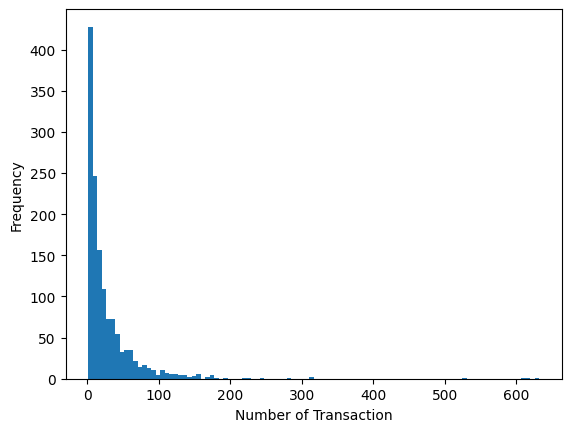

In [8]:
plt.hist(user_transaction_df['BillNo'], bins=100)
# plt.title('Number of Transaction per Customer ')
plt.xlabel('Number of Transaction')
plt.ylabel('Frequency')
plt.show()

# Item Analysis

## Number of Unique Items

In [9]:
print('Train Data')
print(f"Num of Unique Items by Name: {df_train.Itemname.str.lower().nunique()}\n")

print("Test Data")
print(f"Num of Unique Items by Name: {df_test.Itemname.str.lower().nunique()}\n")

print("All Data")
print(f"Num of Unique Items by Name: {pd.concat([df_train, df_test]).Itemname.str.lower().nunique()}")

Train Data
Num of Unique Items by Name: 2523

Test Data
Num of Unique Items by Name: 1752

All Data
Num of Unique Items by Name: 2641


In [10]:
train_items = df_train.Itemname.str.lower().unique()
test_items = df_test.Itemname.str.lower().unique()  

test_not_in_train_items = len([x for x in test_items if x not in train_items])
print(f"Number of Customer in test but not in train: {test_not_in_train_items}")

Number of Customer in test but not in train: 118


In [11]:
import re

def remove_color(string):
    # remove color from the item
    string = re.sub(r'\b(white|red|blue|green|yellow|black|orange|purple|pink)\b', '', string.lower())
    
    # remove special characters
    string = re.sub(r'[^a-zA-Z0-9\s]', '', string)
    
    # remove extra spaces
    string = re.sub('\s+', ' ', string)
    
    return string.upper().strip()

df_train['Itemname'] = df_train['Itemname'].apply(remove_color)
df_test['Itemname'] = df_test['Itemname'].apply(remove_color)

In [12]:
print('Train Data')
print(f"Num of Unique Items by Name: {df_train.Itemname.str.lower().nunique()}\n")

print("Test Data")
print(f"Num of Unique Items by Name: {df_test.Itemname.str.lower().nunique()}\n")

print("All Data")
print(f"Num of Unique Items by Name: {pd.concat([df_train, df_test]).Itemname.str.lower().nunique()}")

Train Data
Num of Unique Items by Name: 2337

Test Data
Num of Unique Items by Name: 1638

All Data
Num of Unique Items by Name: 2444


In [13]:
train_items = df_train.Itemname.str.lower().unique()
test_items = df_test.Itemname.str.lower().unique()  

test_not_in_train_items = len([x for x in test_items if x not in train_items])
print(f"Number of items in test but not in train: {test_not_in_train_items}")

Number of items in test but not in train: 107


## Most Bought Items

In [14]:
item_dist_df = df_train.groupby('Itemname').agg({'BillNo':'count'}).sort_values('BillNo', ascending= False)
top_20_popular_items = item_dist_df.reset_index()[['Itemname']].head(20)
print(f'Number of Items: {item_dist_df.shape[0]:,.0f}')
display(item_dist_df.head(20).reset_index())
# display(item_dist_df.describe())

Number of Items: 2,337


,Itemname,BillNo
0,ALARM CLOCK BAKELIKE,443
1,HANGING HEART TLIGHT HOLDER,440
2,SET OF 3 CAKE TINS PANTRY DESIGN,230
3,REGENCY CAKESTAND 3 TIER,225
4,3 PIECE POLKADOT CUTLERY SET,210
5,HEART OF WICKER LARGE,195
6,REX CASHCARRY JUMBO SHOPPER,192
7,RETROSPOT HEART HOT WATER BOTTLE,163
8,HOME BUILDING BLOCK WORD,158
9,NATURAL SLATE HEART CHALKBOARD,157


## Time Between User Buy the Same Item
We want to know how long the user buys the same item.

In [22]:
item_cust_df = df_train.groupby(['CustomerID','Itemname']).agg({'BillNo':'count'}).reset_index()
item_more_than_2_cust_df = item_cust_df.loc[item_cust_df.BillNo > 1]

item_more_than_2_user_dict = {}
unique_user = item_more_than_2_cust_df.CustomerID.unique()

for cust in unique_user:
    item_more_than_2_user_dict[cust] = item_more_than_2_cust_df.loc[item_more_than_2_cust_df.CustomerID == cust]['Itemname'].unique()

In [23]:
df_train['time_delta'] = 0

In [24]:
for key, value in item_more_than_2_user_dict.items():
    for item in value:
        dummy = df_train.loc[(df_train['CustomerID'] == key) & (df_train['Itemname'] == item)].sort_values('Date', ascending=True).copy()
        dummy['time_delta'] = dummy['Date'].diff().dt.days
        dummy.fillna(0, inplace=True)
        df_train.loc[(df_train['CustomerID'] == key) & (df_train['Itemname'] == item), 'time_delta'] = dummy['time_delta']

In [25]:
df_train.loc[df_train.time_delta > 0]['time_delta'].describe()

count    3783.000000
mean       25.080360
std        18.829579
min         1.000000
25%         8.000000
50%        20.000000
75%        37.000000
max        77.000000
Name: time_delta, dtype: float64

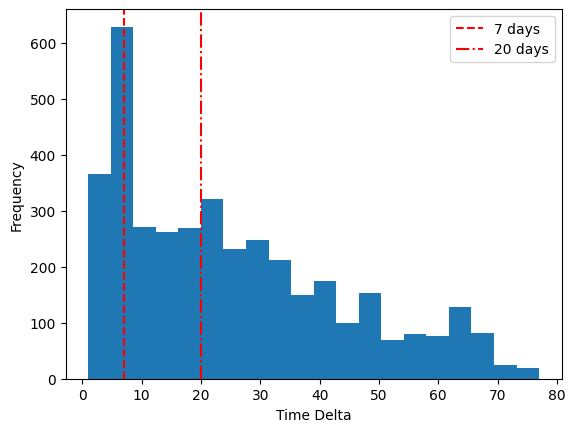

In [ ]:
plt.hist(df_train.loc[df_train.time_delta > 0]['time_delta'], bins=20)
plt.axvline(x=7, color='red', linestyle='dashed', label='7 days')
plt.axvline(x=20, color='red', linestyle='-.', label='20 days')
# plt.title('Histogram of Time Delta between Same Item Purchase from Same Customer')
plt.xlabel('Time Delta')
plt.ylabel('Frequency')
plt.legend()
plt.show()


From this analysis we could know how often the user buys the same item, which is 7 days. Therefore, we could recommend the same item to the user after 7 days.

# Preprocessing

In [15]:
# create validation dataset
df_train.sort_values('Date', inplace=True)

# 20% of the data will be used for validation
number_of_val = int(df_train.shape[0] * 0.2)

# split the data based on the date
data_val = df_train.iloc[-number_of_val:]
data_train = df_train.iloc[:-number_of_val]

print(f"Data Validation Shape: {data_val.shape}")
print(f"Data Train Shape: {data_train.shape}")

Data Validation Shape: (8000, 7)
Data Train Shape: (32000, 7)


In [16]:
# remove new customer on test data
data_test_new_cust = df_test.loc[~df_test.CustomerID.isin(df_train.CustomerID)]
data_test = df_test.loc[df_test.CustomerID.isin(df_train.CustomerID)]

print(f"Test Data Shape with New Customer Removed: {data_test.shape}")
print(f"Number of Unique Customer in Test Data with New Customer Removed: {data_test.CustomerID.nunique()}\n")
print(f"Test Data Shape for New Customer Only: {data_test_new_cust.shape}")
print(f"Number of Unique Customer in Test Data for New Customer Only: {data_test_new_cust.CustomerID.nunique()}")

Test Data Shape with New Customer Removed: (5282, 7)
Number of Unique Customer in Test Data with New Customer Removed: 250

Test Data Shape for New Customer Only: (4718, 7)
Number of Unique Customer in Test Data for New Customer Only: 269


In [17]:
def create_user_item_matrix(dataframe, b_weight=0.4, q_weight=0.4, p_weight=0.2):
    group_data = dataframe.groupby(['CustomerID', 'Itemname']).agg({'BillNo':'count','Quantity':'sum','Price':'median'}).reset_index()
    bill_no_weight = b_weight
    quantity_weight = q_weight
    price_weight = p_weight
    group_data['joined_column'] = (bill_no_weight * group_data['BillNo']) + (quantity_weight* group_data['Quantity']) + (price_weight * 1/group_data['Price'])
        
    # scaler = MinMaxScaler()
    # group_data['joined_column'] = scaler.fit_transform(group_data['joined_column'].values.reshape(-1,1))
    # group_data['joined_column'] = group_data['joined_column'].apply(lambda x: x - np.mean(x))

    # creating customer index
    unique_customers = group_data.CustomerID.unique()
    customer_ids = dict(zip(unique_customers, np.arange(unique_customers.shape[0], dtype=np.int32)))

    # creating item index
    unique_items = group_data.Itemname.unique()
    item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

    # add custimer_id and item_id to the dataframe so that it is an integer from 0 to n-1
    group_data['customer_id'] = group_data.CustomerID.apply(lambda i: customer_ids[i])
    group_data['item_id'] = group_data.Itemname.apply(lambda i: item_ids[i])
    
    sparse_customer_item = sparse.csr_matrix((group_data['joined_column'].astype(float), (group_data['customer_id'], group_data['item_id'])))
    
    row_means = np.array(sparse_customer_item.mean(axis=1)).flatten()
    sparse_customer_item.data -= np.repeat(row_means, np.diff(sparse_customer_item.indptr))

    return sparse_customer_item, group_data, customer_ids, item_ids




# Model Comparison

In this step, we will try different implicit rating calculation and compare the result. There are 3 main variables that will be used as the implicit rating calculation, which are: Count of the Bill Number, Sum of the Quantity and the Price Inverse. Firstly, we will calculate the implicit rating for Bill Number, Quantity and the combination of both variable. Alternating Least Squares (ALS) will be used as the model to predict the rating. Then, we will compare the result of the model in the validation data.

In [81]:
model_list = []
map_list = []
ndcg_list = []
time_list = []
b_var = [1, 0, 0.4]
q_var = [0, 1, 0.4]
p_var = [0, 0, 0.2]
k = 20

## Implicit Rating Using Count of Bill Number

In [82]:
sparse_customer_item_train, grouped_data_train, customer_ids, item_ids =create_user_item_matrix(data_train, b_var[0], q_var[0], p_var[0])
sparse_customer_item_val, grouped_data_val, _, _ =create_user_item_matrix(data_val, b_var[0], q_var[0], p_var[0])

In [83]:
start_time = time.time()
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.01, iterations=100, random_state=3)

model.fit(sparse_customer_item_train)
end_time = time.time()
elapsed_time = end_time - start_time

map = mean_average_precision_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)
ndcg = ndcg_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)

model_list.append('Bill No: 1, Quantity: 0, Price: 0')
map_list.append(map)
ndcg_list.append(ndcg)
time_list.append(elapsed_time)

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


## Implicit Rating Using Sum of Quantity

In [84]:
sparse_customer_item_train, grouped_data_train, customer_ids, item_ids =create_user_item_matrix(data_train, b_var[1], q_var[1], p_var[1])
sparse_customer_item_val, grouped_data_val, _, _ =create_user_item_matrix(data_val, b_var[1], q_var[1], p_var[1])


In [85]:
start_time = time.time()
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.01, iterations=100, random_state=3)

model.fit(sparse_customer_item_train)
end_time = time.time()
elapsed_time = end_time - start_time

map = mean_average_precision_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)
ndcg = ndcg_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)

model_list.append('Bill No: 0, Quantity: 1, Price: 0')
map_list.append(map)
ndcg_list.append(ndcg)
time_list.append(elapsed_time)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


## Implicit Rating Using Combination of the Variables

In [86]:
sparse_customer_item_train, grouped_data_train, customer_ids, item_ids =create_user_item_matrix(data_train, b_var[2], q_var[2], p_var[2])
sparse_customer_item_val, grouped_data_val, _, _ =create_user_item_matrix(data_val, b_var[2], q_var[2], p_var[2])


In [87]:
start_time = time.time()
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.01, iterations=100, random_state=3)

model.fit(sparse_customer_item_train)
end_time = time.time()
elapsed_time = end_time - start_time

map = mean_average_precision_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)
ndcg = ndcg_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)

model_list.append('Bill No: 0.4, Quantity: 0.4, Price: 0.2')
map_list.append(map)
ndcg_list.append(ndcg)
time_list.append(elapsed_time)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


## Comparison

In [88]:
model_evaluation_df = pd.DataFrame({'Implicit Rating Calculation':model_list, 'MAP':map_list, 'NDCG':ndcg_list})
model_evaluation_df.sort_values(['MAP','NDCG'], ascending=False, inplace=True)
model_evaluation_df

,Implicit Rating Calculation,MAP,NDCG
1,"Bill No: 0, Quantity: 1, Price: 0",0.006486,0.025789
0,"Bill No: 1, Quantity: 0, Price: 0",0.006429,0.025649
2,"Bill No: 0.4, Quantity: 0.4, Price: 0.2",0.006370,0.025120


## Hyperparameter Tunning

In [89]:
sparse_customer_item_train, grouped_data_train, customer_ids, item_ids =create_user_item_matrix(data_train,b_weight=1, q_weight=0, p_weight=0)
sparse_customer_item_val, grouped_data_val, _, _ =create_user_item_matrix(data_val,b_weight=1, q_weight=0, p_weight=0)


In [90]:
# Define hyperparameters and their possible values
param_grid = {
    'factor': [12,64,128],
    'regularization': [0.01, 0.1, 0.5,1]
}

# Create a list to store the combinations of hyperparameters
param_combinations = []

# Get all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))
results = []
# Iterate over each combination of hyperparameters
for params in tqdm(param_combinations):
    # Set the hyperparameters to the current combination
    factor = params[0]
    regularization = params[1]

    # Train and evaluate your model using the current hyperparameters
    model = implicit.als.AlternatingLeastSquares(factors=factor, regularization=regularization, iterations=100, random_state=3)

    model.fit(sparse_customer_item_train, show_progress=False)
    
    # model = YourModel(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
    map = mean_average_precision_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)
    ndcg = ndcg_at_k(model, sparse_customer_item_train, sparse_customer_item_val, K=k, show_progress=False)

    # Store the evaluation metric or any other relevant information
    results.append({
        'params': params,
        'map': map,
        'ndcg': ndcg
    })

# Analyze the results and choose the best set of hyperparameters
best_params = max(results, key=lambda x: x['map'])['params']
best_map = max(results, key=lambda x: x['map'])['map']
print("Best hyperparameters:", best_params)
print("Best map:", best_map)


100%|██████████| 12/12 [05:32<00:00, 27.70s/it]

Best hyperparameters: (64, 0.1)
Best map: 0.007016955948806132


In [91]:
hp_result = pd.DataFrame(results)
hp_result.sort_values('map', ascending=False, inplace=True)
hp_result


,params,map,ndcg
5,"(64, 0.1)",0.007017,0.026829
8,"(128, 0.01)",0.006927,0.026950
6,"(64, 0.5)",0.006918,0.026648
7,"(64, 1)",0.006877,0.026226
9,"(128, 0.1)",0.006738,0.026208
10,"(128, 0.5)",0.006593,0.025813
11,"(128, 1)",0.006526,0.025306
4,"(64, 0.01)",0.006347,0.025755
2,"(12, 0.5)",0.005936,0.025353
0,"(12, 0.01)",0.005913,0.025245


# Recommendation for Testing Data
In this step, we will use all of the training data

In [18]:
sparse_customer_item_train, grouped_df_train, customer_ids, item_ids =create_user_item_matrix(df_train, b_weight=0, q_weight=1, p_weight=0)
sparse_customer_item_test, grouped_df_test, _, _ =create_user_item_matrix(data_test,b_weight=0, q_weight=1, p_weight=0)

In [21]:
start_time = time.time()
model = implicit.als.AlternatingLeastSquares(factors=64, regularization=0.1, iterations=100, random_state=3)

model.fit(sparse_customer_item_train)
end_time = time.time()
elapsed_time = end_time - start_time

map = mean_average_precision_at_k(model, sparse_customer_item_train, sparse_customer_item_test, K=k, show_progress=False)
ndcg = ndcg_at_k(model, sparse_customer_item_train, sparse_customer_item_test, K=k, show_progress=False)

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


In [22]:
print(f"Test MAP: {map} | Test NDCG: {ndcg}")

Test MAP: 0.007653696326429662 | Test NDCG: 0.02750705536217547


# Item recommendation for user in Test Data

In [23]:
list_new_cust = data_test_new_cust.CustomerID.unique()
top_20_popular_items['score'] = np.nan
top_20_popular_items.rename({'Itemname':'Recommended Items'}, axis=1, inplace=True)

In [24]:
cust_test = df_test.CustomerID.sample(5, random_state=1).unique()
cust_test

array(['16221', '15078', '17027', '14532', '15092'], dtype=object)

In [38]:
def item_recommendation(user_id):
    # recommend items for a user
    df_test_cust_ = df_test.loc[df_test.CustomerID == user_id]
    
    if user_id in list_new_cust:
        recommendations_df = top_20_popular_items.copy()
    else:
        user = customer_ids[user_id]
        recommendations = model.recommend(user, sparse_customer_item_train[user], N=20, filter_already_liked_items= False)

        descriptions = []
        scores = []

        for idx in recommendations[0]:
            descriptions.append(grouped_df_train.Itemname.loc[grouped_df_train.item_id == idx].iloc[0])
            
        for s in recommendations[1]:
            scores.append(s)
        # descriptions
        recommendations_df = pd.DataFrame({'Recommended Items': descriptions, 'score': scores})
        
    merged_df = pd.merge(df_test_cust_, recommendations_df, left_on='Itemname', right_on='Recommended Items', how='right')
    # merged_df = merged_df.groupby(['BillNo','Itemname','CustomerID','Recommended Items']).agg({'Quantity':'sum','score':'median'}).reset_index()
    merged_df = merged_df.dropna().reset_index(drop=True)[['BillNo','Date','Recommended Items','score']]
    return merged_df

In [39]:
for cust in cust_test:
    if cust in list_new_cust:
        print(f"customer id: {cust} is a new customer")
    else:
        print(f"customer id: {cust}")
        # item_recommendation_df = item_recommendation(cust)
        
    print(f"Number of Bill: {df_test.loc[df_test.CustomerID == cust]['BillNo'].nunique()}")
    print(f"Number of Items actual bought: {df_test.loc[df_test.CustomerID == cust]['Itemname'].nunique()}")
    display(item_recommendation(cust).sort_values('Date').reset_index(drop=True))

customer id: 16221
Number of Bill: 1
Number of Items actual bought: 17


,BillNo,Date,Recommended Items,score
0,546062.0,2011-03-09 10:51:00,HANGING HEART TLIGHT HOLDER,0.995529
1,546062.0,2011-03-09 10:51:00,REX CASHCARRY JUMBO SHOPPER,0.366932


customer id: 15078
Number of Bill: 2
Number of Items actual bought: 34


,BillNo,Date,Recommended Items,score
0,544660.0,2011-02-22 13:47:00,JUMBO BAG SPACEBOY DESIGN,0.810960
1,544660.0,2011-02-22 13:47:00,REGENCY CAKESTAND 3 TIER,0.769051
2,545035.0,2011-02-25 17:03:00,JUMBO BAG SCANDINAVIAN PAISLEY,1.000856
3,545035.0,2011-02-25 17:03:00,JUMBO BAG STRAWBERRY,0.997085
4,545035.0,2011-02-25 17:03:00,RECYCLING BAG RETROSPOT,0.973603
5,545035.0,2011-02-25 17:03:00,JUMBO BAG TOYS,0.957684
6,545035.0,2011-02-25 17:03:00,JUMBO BAG WOODLAND ANIMALS,0.947796
7,545035.0,2011-02-25 17:03:00,SET5 RETROSPOT LID GLASS BOWLS,0.848226
8,545035.0,2011-02-25 17:03:00,JUMBO STORAGE BAG SKULLS,0.820725
9,545035.0,2011-02-25 17:03:00,LUNCH BAG RETROSPOT,0.792741


customer id: 17027
Number of Bill: 2
Number of Items actual bought: 38


,BillNo,Date,Recommended Items,score
0,545166.0,2011-02-28 14:03:00,SET OF 3 CAKE TINS PANTRY DESIGN,0.974361
1,545166.0,2011-02-28 14:03:00,SET OF 6 SPICE TINS PANTRY DESIGN,0.799058
2,545166.0,2011-02-28 14:03:00,6 RIBBONS RUSTIC CHARM,0.785779
3,545166.0,2011-02-28 14:03:00,RIBBON REEL STRIPES DESIGN,0.767210
4,545166.0,2011-02-28 14:03:00,CHOCOLATE BOX RIBBONS,0.630047
5,545306.0,2011-03-01 13:04:00,RIBBON REEL HEARTS DESIGN,0.821635


customer id: 14532
Number of Bill: 1
Number of Items actual bought: 20


,BillNo,Date,Recommended Items,score
0,545037.0,2011-02-27 10:02:00,DOORMAT RETROSPOT,1.139987
1,545037.0,2011-02-27 10:02:00,DOORMAT HEARTS,1.021726
2,545037.0,2011-02-27 10:02:00,DOORMAT UNION FLAG,0.949052
3,545037.0,2011-02-27 10:02:00,DOORMAT NEW ENGLAND,0.899248
4,545037.0,2011-02-27 10:02:00,DOORMAT SPOTTY HOME SWEET HOME,0.874043
5,545037.0,2011-02-27 10:02:00,DOORMAT ENGLISH ROSE,0.842328
6,545037.0,2011-02-27 10:02:00,DOORMAT WELCOME PUPPIES,0.750331
7,545037.0,2011-02-27 10:02:00,DOORMAT 3 SMILEY CATS,0.733514
8,545037.0,2011-02-27 10:02:00,DOORMAT TOPIARY,0.694435
9,545037.0,2011-02-27 10:02:00,DOORMAT HOME SWEET HOME,0.668032


customer id: 15092 is a new customer
Number of Bill: 1
Number of Items actual bought: 13


,BillNo,Date,Recommended Items,score
